In [118]:
class_names = dict(
    (
        (0, 'Build-up'),
        (1, 'Farmland'),
        (2, 'Forest'),
        (3, 'Meadow'),
        (4, 'Water')
    )
)

class_names

{0: 'Build-up', 1: 'Farmland', 2: 'Forest', 3: 'Meadow', 4: 'Water'}

Dictionary for land types.

In [119]:
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

stacked_path = 'D:/DATA/LULC/01_Prepare/Sentinel2/06_test_dataset/test_S2A_MSIL2A_20210921T025551_N9999_R032_T50_20221119T225446_super_resolved_mosaic_stack_DEM_slope_collocation.tif'

# Open raster dataset
sentinel_dataset = rasterio.open(stacked_path)

# How many bands does this image have?
num_bands = sentinel_dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and colums
rows , cols = sentinel_dataset.shape
print('Image size is {r} rows * {c} colums\n'.format(r=rows,c=cols))

# What drivers was used to open the raster
driver = sentinel_dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is raster's projection?
proj = sentinel_dataset.crs
print('Image projection:')
print(proj)

Number of bands in image: 18

Image size is 1625 rows * 2521 colums

Raster driver: GTiff

Image projection:
EPSG:32650


Open up the dataset and read it in memory

In [120]:
sentinel_image = sentinel_dataset.read()
sentinel_image.shape

(18, 1625, 2521)

In [121]:
ndvi = sentinel_image[13,: ,: ]

print('\nMax NDVI: {m:.2f}'.format(m=ndvi.max()))
print('\nMean NDVI: {m:2f}'.format(m=ndvi.mean()))
print('\nMedian NDVI: {m:2f}'.format(m=np.median(ndvi)))
print('\nMin NDVI: {m:2f}'.format(m=ndvi.min()))


Max NDVI: 1.00

Mean NDVI: 0.378570

Median NDVI: 0.350686

Min NDVI: -0.995565


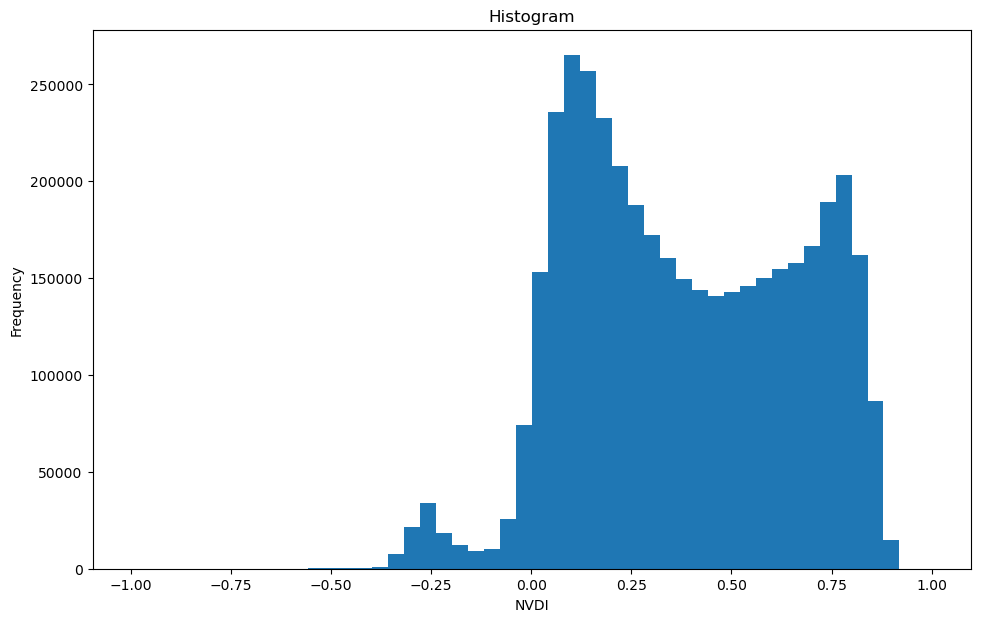

In [122]:
figure, axs = plt.subplots(figsize=(1.62*7,7))
# We can set the number of bins with the `bins` kwarg
axs.hist(ndvi.flatten(), bins=50) # flatten()是对多维数据的降维函数。
plt.title("Histogram")
plt.xlabel("NVDI")
plt.ylabel("Frequency")
plt.show()

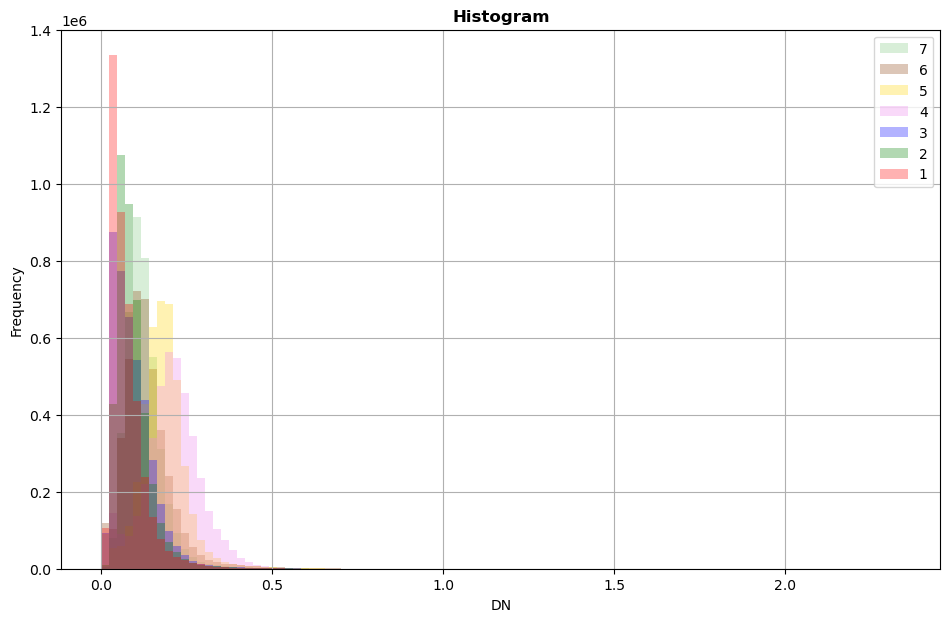

In [123]:
# Whole image histogram

from rasterio.plot import show

figure, axs = plt.subplots(figsize=(1.62*7,7))

rasterio.plot.show_hist(sentinel_dataset.read([1,2,3,4,5,6,7]), 
                        bins=100, 
                        histtype='stepfilled', 
                        lw=0.0, 
                        stacked=False, 
                        alpha=0.3,
                        ax = axs,
                        title="Histogram",
                        label=[1,2,3,4,5,6,7]
                       )
axs.set_xlabel('DN')
_ = axs.set_ylabel('Frequency')

Now visualize the sentinel image and NDVI side by side

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1625, 2521)
(1625, 2521, 3)


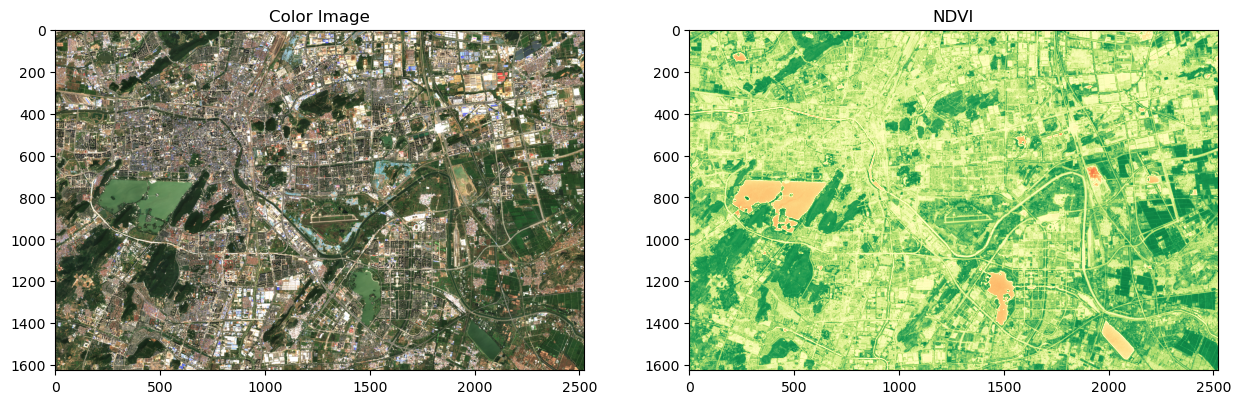

In [124]:
from rasterio.plot import adjust_band
from rasterio.plot import reshape_as_raster, reshape_as_image

# pull out the bands we want to visualize
index = np.array([2, 1, 0])
# sentinel_dataset can cause error: 'DatasetReader' object is not subscriptable
colors = sentinel_image[index, :, :].astype(np.float64)

# we'll use the values to stretch the landsat image based on the above histogram
max_val = 2500
min_val = 0

# enforce maximum and minimum values


# colors[colors[:, :, :] > max_val] = max_val
# colors[colors[:, :, :] < min_val] = min_val

# for b in range(colors.shape[0]):
#     colors[b, :, :] = colors[b, :, :] * 1 / (max_val - min_val)



# rasters are in the format [bands, rows, cols] whereas images are typically [rows, cols, bands]
# and so our array needs to be reshaped
print(colors.shape)
colors_reshaped = reshape_as_image(colors)
print(colors_reshaped.shape)

fig, axs = plt.subplots(1, 2, figsize=(15, 15)) 

# Show the color image
axs[0].imshow(colors_reshaped*5)
axs[0].set_title('Color Image')

# Show NDVI
axs[1].imshow(ndvi, cmap='RdYlGn')
axs[1].set_title('NDVI')

plt.show()

Import training vector files.

In [125]:
import shapely
from shapely import geometry
import fiona

# Open the dataset from file

vector_path = 'D:/DATA/LULC/02_Training/01_test/test_training_merged.shp'

test_training = fiona.open(vector_path)

if not test_training:
    print('Error: Could not open file')

In [126]:
# Driver of this file

driver = test_training.driver
print('Dataser driver is {d}\n'.format(d=driver))

# How many features are contained in this file
feature_count = len(test_training)
print('The shapefile has {n} features.\n'.format(n=feature_count))

# Projection
spatial_ref = test_training.crs
print('The shapefile spatial ref is: \n', spatial_ref, '\n')

# Let's pull out a specific feature from the shapefile
feature = test_training[0]

### What is the features's geometry? is it a point? a polyline? a polygon?
geometry = feature['geometry']['type']
print("The features's geometry is: {geom}\n".format(geom=geometry))

### How many properties are in the shapefile, and what are their names?
properties = feature["properties"].keys()

# How many fields
field_count = len(properties)
print('Layer has {n} fields'.format(n=field_count))

# What are their names?
print('Their names are: ')
for prop in properties:
    print('\t{name}'.format(name=prop))

Dataser driver is ESRI Shapefile

The shapefile has 164 features.

The shapefile spatial ref is: 
 {'init': 'epsg:32650'} 

The features's geometry is: Polygon

Layer has 1 fields
Their names are: 
	class


In [127]:
test_training.meta

{'driver': 'ESRI Shapefile',
 'schema': {'properties': OrderedDict([('class', 'str:80')]),
  'geometry': 'Polygon'},
 'crs': {'init': 'epsg:32650'},
 'crs_wkt': 'PROJCS["WGS 84 / UTM zone 50N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32650"]]'}

In [169]:
feature = test_training[0]
feature

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('class', 'build_up')]),
 'geometry': {'type': 'Polygon',
  'coordinates': [[(510897.3464508614, 3794591.5114977746),
    (510952.56538995286, 3794589.0415747645),
    (510953.70388494787, 3794514.912227511),
    (510898.4867216887, 3794515.4813606925),
    (510897.3464508614, 3794591.5114977746)]]}}

In [170]:
feature.keys()

dict_keys(['type', 'id', 'properties', 'geometry'])

In [130]:
print('id: ', feature['id']) #gives the id
print('class ', feature['properties']['class']) # gives the value of the classname attribute

print('\ngeometry: ', feature['geometry']) # gives the geometry, GeoJSON format

id:  0
class  build_up

geometry:  {'type': 'Polygon', 'coordinates': [[(510897.3464508614, 3794591.5114977746), (510952.56538995286, 3794589.0415747645), (510953.70388494787, 3794514.912227511), (510898.4867216887, 3794515.4813606925), (510897.3464508614, 3794591.5114977746)]]}


<class 'shapely.geometry.polygon.Polygon'>


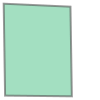

In [131]:
from shapely import geometry
from shapely.geometry import shape
shapely_shape = shape(feature['geometry'])
print(type(shapely_shape))

shapely_shape

In [133]:
# Open raster dataset `sentinel_dataset`

# Read shapefiles straight into a geopandas GeoDataFrame
import geopandas as gpd

shapefile = gpd.read_file(vector_path)
print(shapefile)


        class                                           geometry
0    build_up  POLYGON ((510897.346 3794591.511, 510952.565 3...
1    build_up  POLYGON ((512417.578 3795026.151, 512461.520 3...
2    build_up  POLYGON ((512667.700 3794769.880, 512721.122 3...
3    build_up  POLYGON ((510752.445 3793468.930, 510818.648 3...
4    build_up  POLYGON ((513271.398 3796243.513, 513256.034 3...
..        ...                                                ...
159     water  POLYGON ((513817.645 3782521.504, 513994.162 3...
160     water  POLYGON ((513696.078 3782476.975, 513600.167 3...
161     water  POLYGON ((513493.229 3782566.017, 513503.262 3...
162     water  POLYGON ((512920.059 3786222.273, 513021.270 3...
163     water  POLYGON ((511698.034 3788649.851, 511975.881 3...

[164 rows x 2 columns]


In [134]:
# find the bounding box of the raster and visualize it, These look like lat lon coordinates but let's make sure

from pyproj import CRS

CRS(sentinel_dataset.crs)

<Projected CRS: EPSG:32650>
Name: WGS 84 / UTM zone 50N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 50N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [135]:
CRS(shapefile.crs)

<Projected CRS: EPSG:32650>
Name: WGS 84 / UTM zone 50N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 114°E to 120°E - by country
- bounds: (114.0, 0.0, 120.0, 84.0)
Coordinate Operation:
- name: UTM zone 50N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Get pixels from the raster as outlined in each shapefile

Our training data, the shapefile we've worked with, contains one main field we care about:
+ a class field (String datatype)

Combined with the innate location information of polygons in a Shapefile, we have all that we need to use for pairing labels with the information in our raster.

However, in order to pair up our vector data with our raster pixels, we will need a way of co-aligning the datasets in space. 

We'll do this using the rasterio mask function which takes in a dataset and a polygon and then outputs a numpy array with the pixels in the polygon.

Let's run through an example:


In [136]:
len(shapefile)

164

Now we want to extract the geometry of each feature in the shapefile in GeoJSON format:

In [167]:
# This generates a list of shapely geometrics

geoms = shapefile.geometry.values

# Grab a single shapely geometry to check
geometry = geoms[100]

print(type(geometry))
print(geometry)

# Transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)]
print(type(feature))
print(len(feature))

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((515011.2329183281 3787434.907122181, 514960.4241492219 3787614.765568983, 515052.4925994471 3787959.586050752, 515369.3776987188 3788548.072370816, 515682.4839407543 3788855.24903692, 515955.6797646828 3789104.077936655, 516221.135251377 3788952.471340482, 516055.5336818951 3788559.359465126, 515616.4230213116 3788079.623064, 515448.0952993971 3788038.794501954, 515011.2329183281 3787434.907122181))
<class 'list'>
1


Now lets extract the raster values within the polygon using rasterio [mask() function](https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html)

In [138]:
out_image, out_tranform = mask(sentinel_dataset,feature,crop=True)
out_image.shape

(18, 168, 127)

In [139]:
sentinel_dataset.close

<function DatasetReader.close>

## Building the Training Data for `scikit-learn`

Now let's do it for all features in the shapefile and create an array `X` that has all the pixels and an array `y` that has all the training labels.

In [140]:
X = np.array([], dtype=np.int8).reshape(0,18) # pixels for training
y = np.array([], dtype=np.string_) # labels for training

# Extract raster values within the polygon
with rasterio.open(stacked_path) as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]
        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True) 
        # eliminate all the pixels with 0 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y,[shapefile["class"][index]] * out_image_reshaped.shape[0]) 
        # stack the pizels onto the pixel array
        X = np.vstack((X,out_image_reshaped))  

print(X.shape)
print(y.shape)

(153272, 18)
(153272,)


Now that we have the image we want to classify (our X feature inputs), and the land cover labels (our y labeled data), let's check to make sure they match in size so we can feed them to Naive Bayes:

In [141]:
# What are our classification labels?
labels = np.unique(shapefile["class"])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, 
                                                                classes=labels))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

The training data include 5 classes: ['Forest' 'build_up' 'farmland' 'meadow' 'water']

Our X matrix is sized: (153272, 18)
Our y array is sized: (153272,)


Let's explore the spectral signatures of each class now to make sure they're actually separable since all we're going by in this classification is pixel values.

Text(0.5, 1.0, 'Band Intensities Higher Ref Subset')

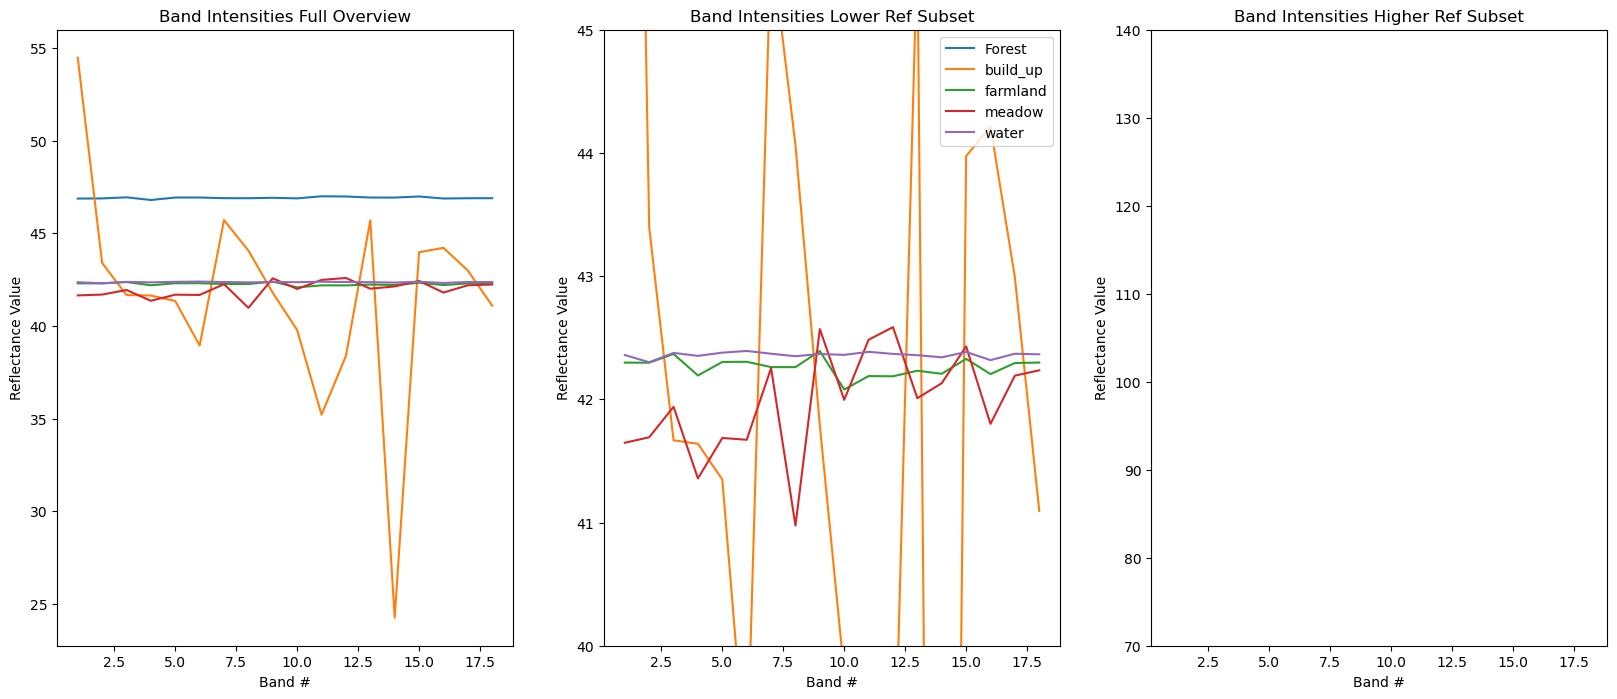

In [142]:
fig, ax = plt.subplots(1,3, figsize=[20,8])

# numbers 1-8
band_count = np.arange(1,19)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax[0].plot(band_count, band_intensity, label=class_type)
    ax[1].plot(band_count, band_intensity, label=class_type)
    ax[2].plot(band_count, band_intensity, label=class_type)
# plot them as lines

# Add some axis labels
ax[0].set_xlabel('Band #')
ax[0].set_ylabel('Reflectance Value')
ax[1].set_ylabel('Reflectance Value')
ax[1].set_xlabel('Band #')
ax[2].set_ylabel('Reflectance Value')
ax[2].set_xlabel('Band #')
#ax[0].set_ylim(32,38)
ax[1].set_ylim(40,45)
ax[2].set_ylim(70,140) 
#ax.set
ax[1].legend(loc="upper right")

# Add a title
ax[0].set_title('Band Intensities Full Overview')
ax[1].set_title('Band Intensities Lower Ref Subset')
ax[2].set_title('Band Intensities Higher Ref Subset')

Let's make a quick helper function, this one will convert the class labels into indicies and then assign a dictionary relating the class indices and their names.

In [143]:
def str_class_to_int(class_array):
    class_array[class_array == 'build_up'] = 0
    class_array[class_array == 'Forest'] = 1
    class_array[class_array == 'farmland'] = 2
    class_array[class_array == 'meadow'] = 3
    class_array[class_array == 'water'] = 4
    return(class_array.astype(int))

## Training the Classifier
Now that we have our X matrix of feature inputs (the spectral bands) and our y array (the labels), we can train our model.

Visit [this web page to find the usage of GaussianNaiveBayes Classifier](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes) from `scikit-learn`.

In [144]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X, y)

GaussianNB()

## Predicting on the image

With our Naive Bayes classifier fit, we can now proceed by trying to classify the entire image:

We're only going to open the subset of the image we viewed above because otherwise it is computationally too intensive for most users.

In [165]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image

with rasterio.open(stacked_path) as src:
    img = src.read()[:,150:600,150:600]

print(img.shape)

reshape_img = reshape_as_image(img)
print(reshape_img.shape)

(18, 450, 450)
(450, 450, 18)


In [163]:
# Now we can predict for each pixel in our image

class_prediction = gnb.predict(reshape_img.reshape(-1,18))


# Reshape our classification map back into a 2D matrix so we can visualize it
class_prediction = class_prediction.reshape(reshape_img[:, :, 0].shape)
print(class_prediction)

ValueError: Expected 2D array, got scalar array instead:
array=<built-in method reshape of numpy.ndarray object at 0x000001A4055FD1B0>.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Because our shapefile came with the labels as strings we want to convert them to a numpy array with ints using the helper function we made earlier.

In [153]:
class_prediction = str_class_to_int(class_prediction)

### Let's visualize it!

First we'll make a colormap so we can visualize the classes, which are just encoded as integers, in more logical colors. Don't worry too much if this code is confusing! It can be a little clunky to specify colormaps for `matplotlib`.

In [156]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (0, (48, 156, 214, 255)),   # Blue - Water
    (1, (139,69,19, 255)),      # Brown - WetSand
    (2, (96, 19, 134, 255)),    # Purple - Emergent Wetland
    (3, (244, 164, 96, 255)),   # Tan - Sand
    (4, (206, 224, 196, 100)),  # Lime - Herbaceous
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

Now show the classified map next to the RGB image!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


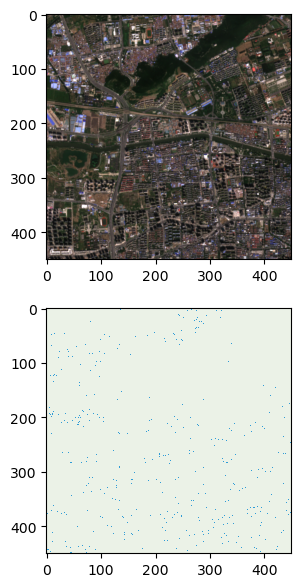

In [161]:
%matplotlib inline

fig, axs = plt.subplots(2,1,figsize=(10,7))

img_stretched = color_stretch(reshape_img, [2, 1, 0])
axs[0].imshow(img_stretched*5)

axs[1].imshow(class_prediction, cmap=cmap, interpolation='none')